In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as scpo
import shapely as sply

In [3]:
data = gpd.read_file('./data/landkreise_merged_i.geojson')
data = data.set_index('name')

In [4]:
bundeslaender = data[data.art == 'bundesland']
landkreise = data[data.art == 'landkreis']
dateColNames = landkreise.columns[4:-2]
landkreise[dateColNames] = landkreise[dateColNames].astype(np.int64)
bundeslaender[dateColNames] = landkreise.groupby('partof')[dateColNames].sum()
landkreise.current = landkreise.current.astype(np.int64)
bundeslaender.current = landkreise.groupby('partof').current.sum()

In [5]:
laenderNames = bundeslaender.index
laenderIds = np.arange(len(laenderNames))
bayernCuml = bundeslaender.loc['Bayern']
KBayern = bayernCuml['population'] * 0.7

In [6]:
landkreiseBayern = landkreise[landkreise.partof == 'Bayern']
landkreisNames = landkreiseBayern.index
landkreisIds = np.arange(len(landkreisNames))
population = landkreiseBayern['population'].values
Ks = landkreiseBayern['population'] * 0.7
T = len(dateColNames)
time = np.arange(T)
incubationTime = 7
tCurfew = list(dateColNames.values).index('22.03.2020')
tCurfewEffect = tCurfew + incubationTime

### 1. Simple model

In [7]:
def simpleModelBayern(alpha):
    infected = np.zeros(T)
    infected[0] = bayernCuml[dateColNames[0]]
    for t in range(T-1):
        dndt = alpha * infected[t] * (1 - infected[t] / KBayern)
        infected[t+1] = infected[t] + dndt
    return infected

In [8]:
def mseBayern(paras, model):
    y = bayernCuml[dateColNames].values
    y_sim = model(*paras)
    me = np.mean((y - y_sim) * (y - y_sim))
    return me

In [9]:
resultsSimpleBayern = scpo.brute(mseBayern, ((0.01, 5.0),), args=(simpleModel,))
resultsSimpleBayern

NameError: name 'simpleModel' is not defined

In [ ]:
def plotSim(mod, paras):
    y = bayernCuml[dateColNames].values
    ySim = mod(*paras)
    plt.scatter(time, y)
    plt.plot(time, ySim)
    plt.xticks(range(len(dateColNames)), dateColNames.values, rotation=90)

In [ ]:
plotSim(simpleModelBayern, (resultsSimpleBayern[0],))

### 2. Allowing step

In [ ]:
def stepModelBayern(alpha0, alpha1):
    infected = np.zeros(T)
    infected[0] = bayernCuml[dateColNames[0]]
    for t in range(T-1):
        alpha = alpha0 if t < tCurfewEffect else alpha1
        dndt = alpha * infected[t] * (1 - infected[t] / KBayern)
        infected[t+1] = infected[t] + dndt
    return infected

In [ ]:
resultsStepBayern = scpo.brute(mseBayern, ((0.01, 5.0), (0.01, 5.0)), args=(stepModelBayern,))
resultsStepBayern

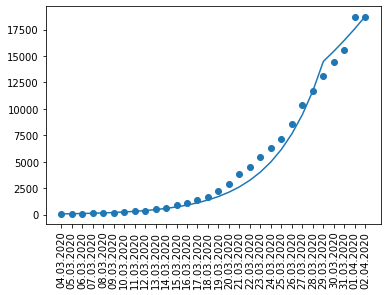

In [14]:
plotSim(stepModelBayern, resultsStepBayern)

### 3. Spatial model

In [15]:
centroids = landkreiseBayern.centroid
connectivity = np.zeros((len(landkreisNames), len(landkreisNames)))
for x in range(len(landkreisNames)):
    for y in range(x, len(landkreisNames)):
        lk1 = landkreiseBayern.index[x]
        lk2 = landkreiseBayern.index[y]
        c = 1.0 / ( centroids[lk1].distance(centroids[lk2]) + 1)**2
        connectivity[x, y] = c
        connectivity[y, x] = c
distanceSum = np.sum(connectivity[0, :])
connectivity = connectivity / distanceSum

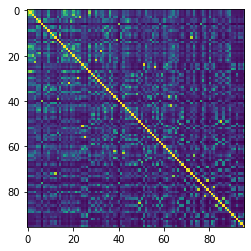

In [16]:
plt.imshow(connectivity)

In [17]:
def spatialModel(alpha0, alpha1):
    infected = np.zeros((len(landkreisIds), T))
    infected[:, 0] = landkreiseBayern[dateColNames[0]].values
    for t in range(T-1):
        alpha = alpha0 if t < tCurfewEffect else alpha1
        conct = connectivity if t < tCurfew else 0.5 * connectivity
        for landkreis in landkreisIds:
            K = Ks[landkreis]  # TODO: maybe K should be a spatially weighted sum, too?
            nc = np.inner( conct[landkreis, :], infected[:, t] )
            dndt = alpha * nc * (1 - infected[landkreis, t] / K)
            infected[landkreis, t+1] = infected[landkreis, t] + dndt
    return infected

In [18]:
def mseSpatial(paras, model):
    y = landkreiseBayern[dateColNames].values
    y_sim = model(*paras)
    me = np.mean((y - y_sim) * (y - y_sim))
    return me

In [19]:
resultsSpatialGD = scpo.minimize(mseSpatial, x0=[1, 0.5], bounds=((0.001, 5.0), (0.001, 5.0)), args=(spatialModel,))
resultsSpatialGD

      fun: 17908.215558375356
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.19899744, -0.00727596])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 105
      nit: 14
   status: 0
  success: True
        x: array([0.32763842, 0.26170169])

In [20]:
resultsSpatialBrt = scpo.brute(mseSpatial, ((0.01, 5.0), (0.01, 5.0)), args=(spatialModel,))
resultsSpatialBrt

array([1.85780989, 0.5814104 ])

In [21]:
def plotSimLks(mod, paras, lkName):
    y = landkreiseBayern[dateColNames].values
    ySim = mod(*paras)
    i = list(landkreiseBayern.index).index(lkName)
    plt.scatter(time, y[i])
    plt.plot(time, ySim[i])
    plt.title(lkName)
    plt.xticks(range(len(dateColNames)), dateColNames.values, rotation=90)

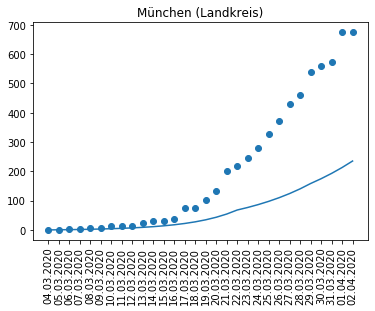

In [22]:
plotSimLks(spatialModel, resultsSpatialGD.x, 'München (Landkreis)')

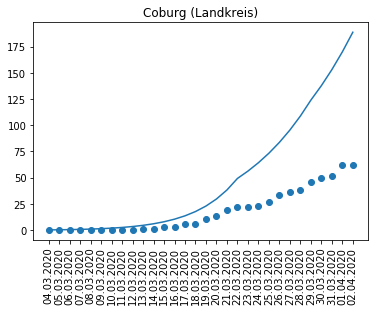

In [23]:
plotSimLks(spatialModel, resultsSpatialGD.x, 'Coburg (Landkreis)')

The simulations don't look very good for individual Landkreise, but they are good when cumulated:

In [33]:
y = landkreiseBayern[dateColNames].values
y_sim = spatialModel(*(resultsSpatialGD.x))
y_cuml = np.sum(y, axis=0)
y_sim_cuml = np.sum(y_sim, axis=0)

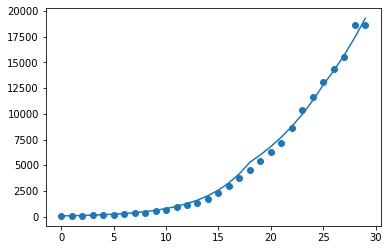

In [34]:
plt.scatter(time, y_cuml)
plt.plot(time, y_sim_cuml)